In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import sklearn.linear_model as linear
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
import sklearn.model_selection as model_select

pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 1000)

"""
选择逻辑分类回归模型  二元分类
"""

# ---------------------------------- get data -------------------------------
df_tmp = pd.read_csv("../data/cleaned_pima_data.csv")
x = df_tmp[["Pregnancies", "Glucose", "BloodPressure", "BMI", "DiabetesPedigreeFunction", "Age"]]
y = df_tmp["Outcome"]

# ---- split train test ------
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=7, test_size=0.25)


# ----------------------fit and select hyper-parameter 选择最优超参数--------------------------

C_lst = [1, 5, 10, 20, 30, 40, 50, 80, 100]
df_acc = pd.DataFrame()

for i in C_lst:
    lr = linear.LogisticRegression(solver="liblinear", C=i)
    lr.fit(x_train, y_train)

    # train accuracy
    train_accuracy = model_select.cross_val_score(lr, x_train, y_train, cv=5, scoring="accuracy")
    train_accuracy_mean = train_accuracy.mean()

    # test accuracy
    test_accuracy = model_select.cross_val_score(lr, x_test, y_test, cv=5, scoring="accuracy")
    test_accuracy_mean = test_accuracy.mean()

    # test f1_score
    test_f1_score = model_select.cross_val_score(lr, x_test, y_test, cv=5, scoring="f1_weighted")
    test_f1_score_mean = test_f1_score.mean()

    # test recall
    test_recall = model_select.cross_val_score(lr, x_test, y_test, cv=5, scoring="recall_weighted")
    test_recall_mean = test_recall.mean()

    # test precision
    test_precision = model_select.cross_val_score(lr, x_test, y_test, cv=5, scoring="precision")
    test_precision_mean = test_precision.mean()

    df_tmp = pd.DataFrame([[train_accuracy_mean, test_accuracy_mean, test_f1_score_mean,
                            test_recall_mean, test_precision_mean]],
                          columns=["train_accuracy", "test_accuracy", "test_f1_score",
                                   "test_recall", "test_precision"], index=[i])

    df_acc = df_acc.append(df_tmp)

df_acc = pd.DataFrame(df_acc, index=C_lst)

In [20]:
df_acc

,train_accuracy,test_accuracy,test_f1_score,test_recall,test_precision
1,0.752027,0.770040,0.753444,0.770040,0.774747
5,0.771053,0.765047,0.754708,0.765047,0.733312
10,0.774531,0.770310,0.760884,0.770310,0.738766
20,0.774531,0.780702,0.773429,0.780702,0.748918
30,0.774531,0.785965,0.779893,0.785965,0.755584
40,0.774531,0.791228,0.785827,0.791228,0.760130
50,0.774531,0.791228,0.785827,0.791228,0.760130
80,0.776255,0.791228,0.785827,0.791228,0.760130
100,0.776255,0.791228,0.785827,0.791228,0.760130


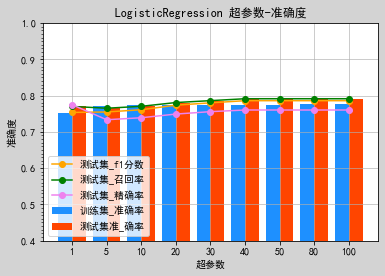

In [21]:
# ------draw plot accuracy-------各个超参数准确率可视化------------------
mp.rcParams["font.sans-serif"] = ["SimHei"]
mp.rcParams["axes.unicode_minus"] = False

mp.figure("LogisticRegression 超参数-准确度", facecolor="lightgray")
mp.title("LogisticRegression 超参数-准确度")
mp.xlabel("超参数")
mp.ylabel("准确度")

bar_x = np.arange(df_acc["train_accuracy"].shape[0])

# mp.bar(bar_x - 0.2, train_accuracy_lst, 0.4, color="dodgerblue", label="训练集_准确率", align="center")
mp.bar(bar_x - 0.2, df_acc["train_accuracy"], 0.4, color="dodgerblue", label="训练集_准确率", align="center")
mp.bar(bar_x + 0.2, df_acc["test_accuracy"], 0.4, color="orangered", label="测试集准_确率", align="center")

mp.plot(bar_x, df_acc["test_f1_score"], "o-", color="orange", label="测试集_f1分数")
mp.plot(bar_x, df_acc["test_recall"], "o-", color="green", label="测试集_召回率")
mp.plot(bar_x, df_acc["test_precision"], "o-", color="violet", label="测试集_精确率")

ax = mp.gca()
ax.yaxis.set_major_locator(mp.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mp.MultipleLocator(0.01))

mp.ylim([0.4, 1])
mp.xticks(bar_x, C_lst)
mp.legend()
mp.grid(":", alpha=0.8)
mp.show()

In [22]:
# --------------------选择最优超参数-------------
sorted_index_lst = df_acc["test_accuracy"].sort_values().index
tar = df_acc.loc[sorted_index_lst, "test_accuracy"]

tar


5      0.765047
1      0.770040
10     0.770310
20     0.780702
30     0.785965
40     0.791228
50     0.791228
80     0.791228
100    0.791228
Name: test_accuracy, dtype: float64

In [23]:
max = df_acc.loc[sorted_index_lst[0], "test_accuracy"], sorted_index_lst[0]

for ind in sorted_index_lst[1:]:
    tmp = df_acc.loc[ind, "test_accuracy"]
    if max[0] < tmp:
        max = tmp, ind

print(max)
# (0.7912280701754385, 40)
# 最优超参数
best_hyper_param = max[1]

best_hyper_param

(0.7912280701754385, 40)


40

In [24]:
# ---------------------------------- 使用最优超参数,训练 -------------------------------
lr = linear.LogisticRegression(solver="liblinear", C=best_hyper_param)
lr.fit(x_train, y_train)

# ---测试准确度----
y_pre = lr.predict(x_test)

# 分类报告
res = sm.classification_report(y_test, y_pre)

print(res)


              precision    recall  f1-score   support

           0       0.78      0.89      0.83       122
           1       0.74      0.57      0.65        70

    accuracy                           0.77       192
   macro avg       0.76      0.73      0.74       192
weighted avg       0.77      0.77      0.76       192

